In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator
from random import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from tqdm import *

In [2]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1133 non-null   int64  
 1   event                 1133 non-null   object 
 2   race                  1133 non-null   object 
 3   country               1133 non-null   object 
 4   participation         1133 non-null   object 
 5   distance              1133 non-null   float64
 6   elevation_gain        1133 non-null   float64
 7   elevation_loss        1133 non-null   float64
 8   aid_stations          1133 non-null   int64  
 9   participants          1133 non-null   int64  
 10  year                  1133 non-null   int64  
 11  month                 1133 non-null   int64  
 12  day                   1133 non-null   int64  
 13  frequency_in_ranking  1133 non-null   int64  
 14  equivalent_distance   1133 non-null   float64
 15  weighted_elevation   

In [3]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.loc[join.speed < 20]
join = join.loc[join.distance > 150]

In [4]:
join_unique = join.drop_duplicates(subset=['runner_id'])

In [180]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

<AxesSubplot:xlabel='equivalent_distance', ylabel='Count'>

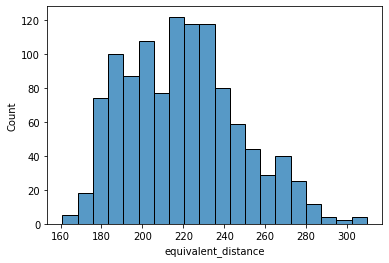

In [5]:
sns.histplot(
    x = race.equivalent_distance[race.distance > 150]
)

<AxesSubplot:xlabel='distance', ylabel='Count'>

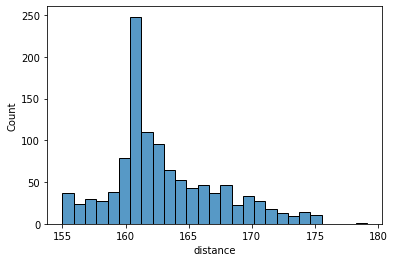

In [6]:
sns.histplot(
    x = race.distance[race.distance > 150]
)

<AxesSubplot:xlabel='equivalent_distance', ylabel='Count'>

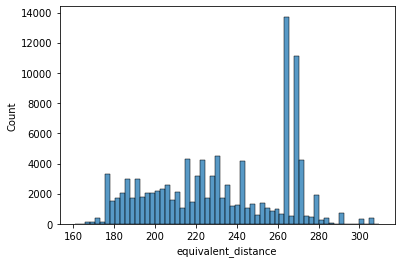

In [7]:
sns.histplot(
    x = join.equivalent_distance[join.equivalent_distance > 150]
)

<AxesSubplot:xlabel='weighted_elevation', ylabel='Count'>

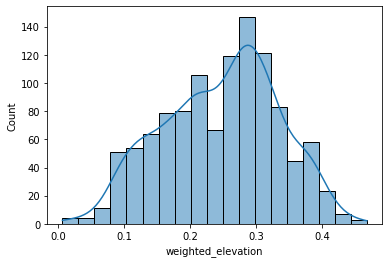

In [8]:
sns.histplot(
    x = race.weighted_elevation[race.distance > 150],
    kde = True
)

<AxesSubplot:xlabel='weighted_elevation', ylabel='equivalent_distance'>

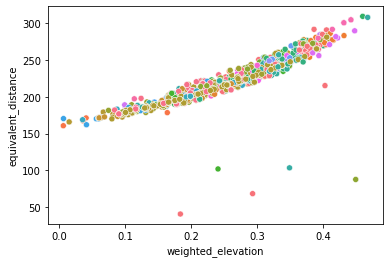

In [9]:
sns.scatterplot(
    x = "weighted_elevation",
    y = "equivalent_distance",
    data = race,
    hue = "country",
    legend = False
)

<AxesSubplot:xlabel='distance', ylabel='equivalent_distance'>

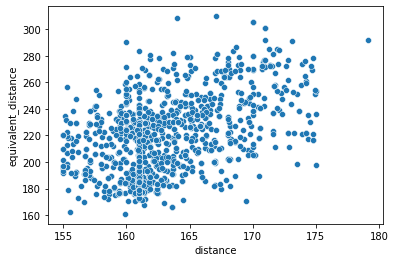

In [10]:
sns.scatterplot(
    x = "distance",
    y = "equivalent_distance",
    data = race[race.distance > 150]
    
)

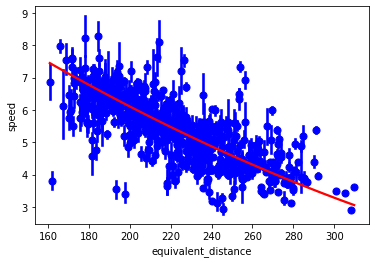

In [11]:
ax = sns.regplot(
    x = "equivalent_distance",
    y = "speed",
    data = join[join.distance > 150],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.mean,
    order = 2
)

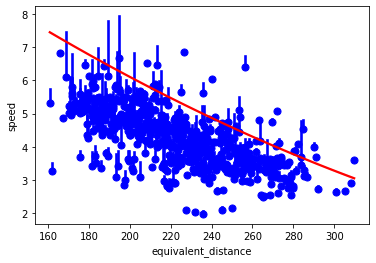

In [12]:
ax = sns.regplot(
    x = "equivalent_distance",
    y = "speed",
    data = join[join.distance > 150],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.min,
    order = 2
)

<AxesSubplot:>

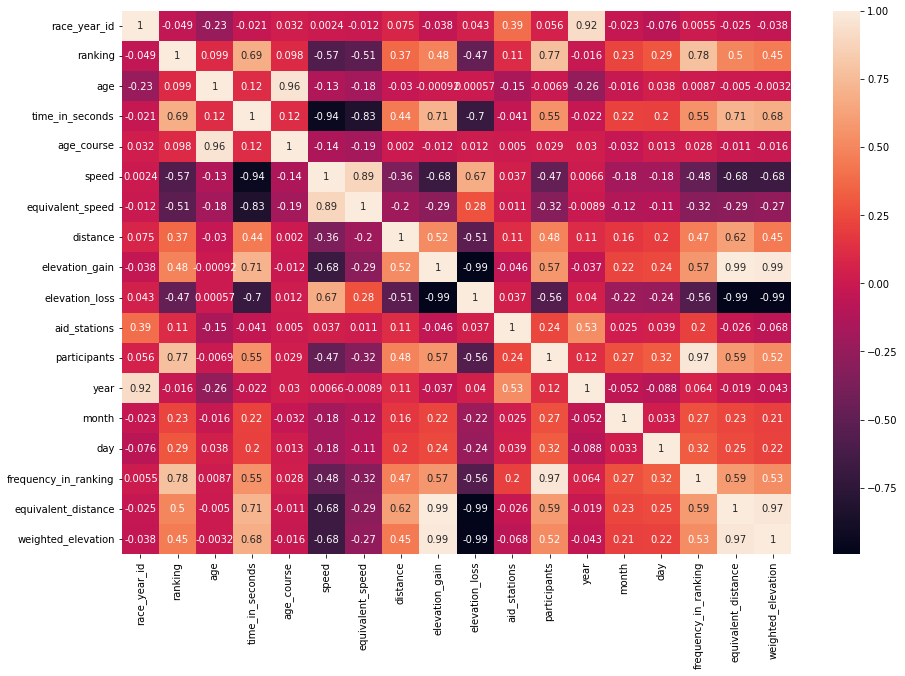

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(join.corr(), annot = True)

In [14]:
def homeCountry(df, th):
    '''
        :param df: join, merge de runners avec races
        :param th: threshold, nombre de courses minimales effectuées par les coureurs
    '''
    runners_occ = df['runner_id'].value_counts().fillna(0).astype(int)
    runners_occ = pd.DataFrame(runners_occ).reset_index()
    runners_occ = runners_occ.rename( columns= {'index':'runner_id','runner_id':'occ'})
    
    pro_runners_id = runners_occ.loc[runners_occ.occ >= th]
    
    res = pd.DataFrame()
    
    for runner in tqdm(pro_runners_id.runner_id):
        runner_info = df.loc[(df.runner_id == runner)]
        
        res = res.append({'runner_id': runner,
                         'nationality': runner_info['nationality'].iloc[0],
                         'total_races': runner_info.shape[0],
                         'home_races': runner_info.loc[runner_info.country == runner_info['nationality']].shape[0],
                         'fore_races': runner_info.loc[runner_info.country != runner_info['nationality']].shape[0]
                       }, ignore_index = True)
    
    
    
    
    res = res.assign(
        perc_home = res.home_races / res.total_races * 100
    )
    return res

In [15]:
res = homeCountry(join, 5)

100%|██████████████████████████████████████| 3237/3237 [00:19<00:00, 168.96it/s]


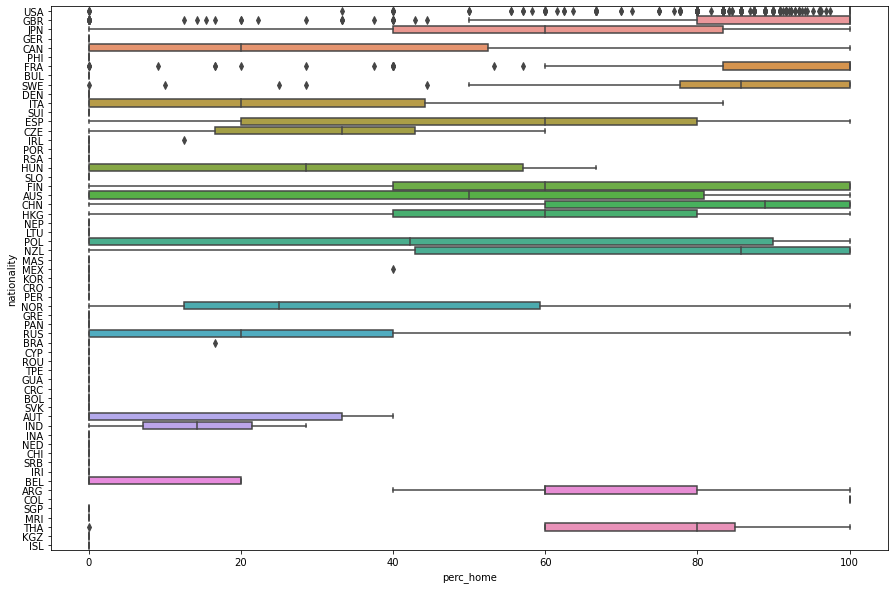

In [16]:
plt.figure(figsize=(15,10))
sns.boxplot(
    x = "perc_home",
    y = "nationality",
    data = res
)
plt.savefig('percentage_home.pdf')

In [17]:
def homeRace(df):
    '''
        :param df: join, merge de runners avec races
    '''
    res = pd.DataFrame()
    
    for race in tqdm(df.race_year_id.unique()):
        runners_in_race = df.loc[(df.race_year_id == race)]
        
        res = res.append({'race_year_id': race,
                          'total_runners': runners_in_race.shape[0],
                          'home_runners': runners_in_race.loc[runners_in_race.nationality == runners_in_race['country']].shape[0],
                          'fore_runners': runners_in_race.loc[runners_in_race.nationality != runners_in_race['country']].shape[0]
                       }, ignore_index = True)
    
    
    
    
    res = res.assign(
        perc_home = res.home_runners / res.total_runners * 100,
        perc_fore = res.fore_runners / res.total_runners * 100
    )
    return res

In [18]:
res2 = homeRace(join)

100%|██████████████████████████████████████| 1119/1119 [00:01<00:00, 755.28it/s]


In [19]:
new_race = pd.merge(race, res2, left_on="race_year_id", right_on="race_year_id", how="left")
new_race = new_race.dropna()

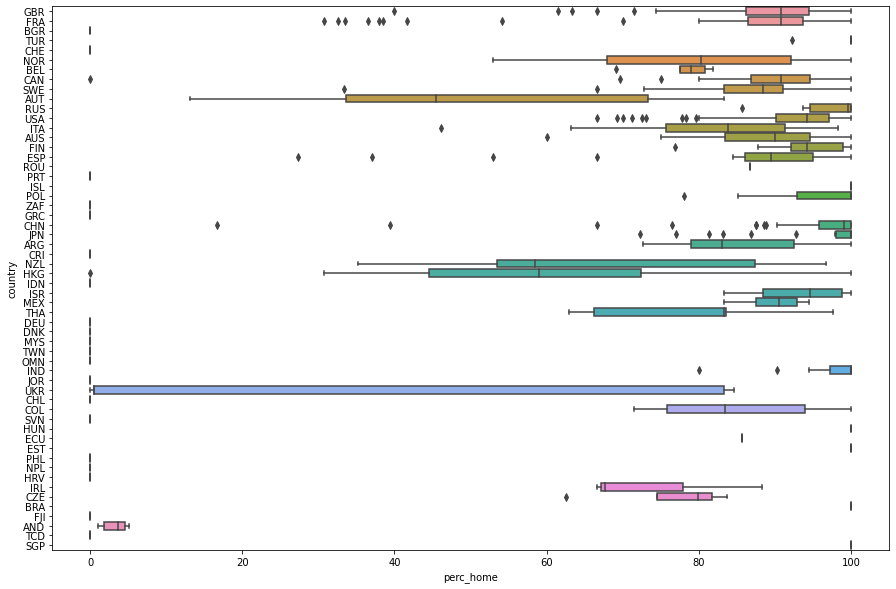

In [20]:
plt.figure(figsize=(15,10))
sns.boxplot(
    x = "perc_home",
    y = "country",
    data = new_race
)
plt.savefig('percentage_home_race.pdf')

<AxesSubplot:xlabel='year', ylabel='perc_fore'>

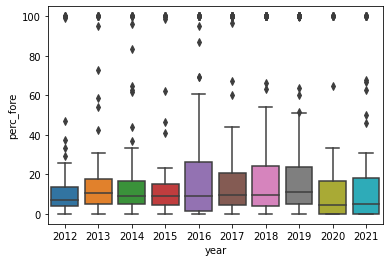

In [21]:
sns.boxplot(
    y = 'perc_fore',
    x = 'year',
    data = new_race
)


### Pourcentage d'étrangers moyens par course

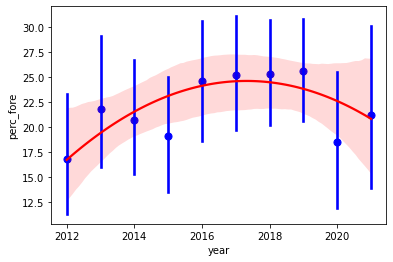

In [22]:
ax = sns.regplot(
    x = "year",
    y = "perc_fore",
    data = new_race,
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    x_estimator=np.mean,
    order = 2
)

<AxesSubplot:xlabel='country', ylabel='count'>

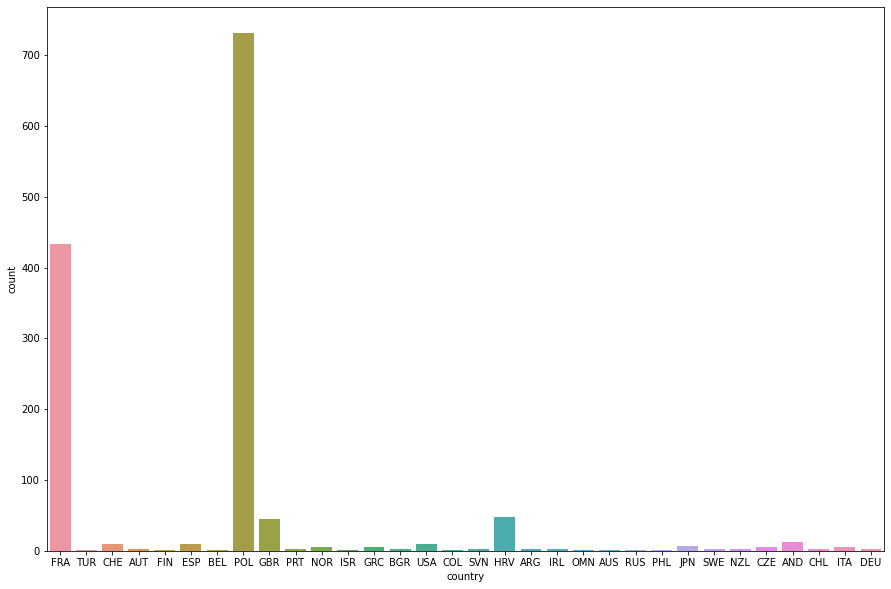

In [23]:
plt.figure(figsize=(15,10))

sns.countplot(
    x = 'country',
    data = join.loc[join.nationality == "POL"]
)

<AxesSubplot:xlabel='perc_fore', ylabel='country'>

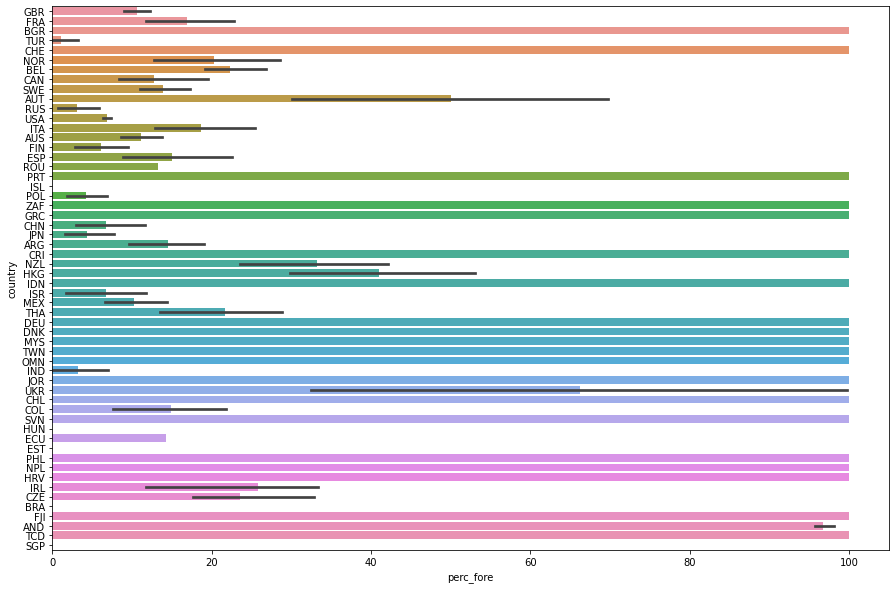

In [24]:
plt.figure(figsize=(15,10))
sns.barplot(
    x = "perc_fore",
    y = "country",
    data = new_race
)

In [25]:
new_race[new_race.country == "FRA"].sort_values('perc_fore')

,race_year_id,event,race,country,participation,distance,elevation_gain,elevation_loss,aid_stations,participants,...,month,day,frequency_in_ranking,equivalent_distance,weighted_elevation,total_runners,home_runners,fore_runners,perc_home,perc_fore
160,53283,LE DERNIER HOMME DEBOUT MORVAN,24 Boucles,FRA,solo,169.90,5740.0,-5740.0,1,350,...,1,25,6,227.30,0.252530,6.0,6.0,0.0,100.000000,0.000000
137,50051,Infinity Trail Backyard - Normandie,Infinity Trail - 23 boucles,FRA,solo,155.30,5160.0,-5160.0,1,80,...,7,31,2,206.90,0.249396,2.0,2.0,0.0,100.000000,0.000000
500,31523,Les Traces du Nord Basse-Terre,L'Ultra-Trail®,FRA,solo,155.40,6290.0,-6300.0,14,400,...,2,16,10,218.30,0.288136,10.0,10.0,0.0,100.000000,0.000000
724,10563,GRAND TRAIL STEVENSON,GTS 3 jours - B,FRA,solo,156.20,5143.0,-5986.0,6,23,...,7,15,23,207.63,0.247700,23.0,23.0,0.0,100.000000,0.000000
1070,2871,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,FRA,solo,168.90,10982.0,-10952.0,0,1363,...,10,18,1363,278.72,0.394015,1208.0,1167.0,41.0,96.605960,3.394040
2,69855,Grand Raid des Pyrénées,Ultra Tour 160,FRA,solo,167.00,9980.0,-9980.0,13,600,...,8,20,455,266.80,0.374063,237.0,228.0,9.0,96.202532,3.797468
128,61035,ULTRA 01,Ultra 165km,FRA,solo,167.20,7230.0,-7230.0,8,300,...,8,21,231,239.50,0.301879,147.0,140.0,7.0,95.238095,4.761905
21,68778,Ultra Tour des 4 Massifs,Ut4M 160 Challenge,FRA,solo,173.10,11810.0,-11710.0,12,545,...,7,15,545,291.20,0.405563,410.0,390.0,20.0,95.121951,4.878049
987,4870,Le Grand Raid De La Réunion,Le Grand Raid De La Réunion,FRA,solo,164.60,10100.0,-10060.0,0,1363,...,10,17,1363,265.60,0.380271,1271.0,1205.0,66.0,94.807238,5.192762
450,29115,ULTRA01 by XT,ULTRA01 by XT,FRA,solo,163.30,5010.0,-5010.0,5,200,...,6,22,115,213.40,0.234770,115.0,109.0,6.0,94.782609,5.217391


In [26]:
new_race.loc[new_race.race_year_id == 11263]['year']

707    2016
Name: year, dtype: int64

In [33]:
French = join.loc[join.nationality == "FRA"]
runners_occ = French['runner_id'].value_counts().fillna(0).astype(int)
runners_occ = pd.DataFrame(runners_occ).reset_index()
runners_occ = runners_occ.rename( columns= {'index':'runner_id','runner_id':'occ'})


pro_runners_id = runners_occ.loc[runners_occ.occ >= 10]
pro_runners_id

,runner_id,occ
0,JOUFFROYRomainFRAM43.0,16
1,GUILLONAntoineFRAM51.0,15
2,BALAHACHIRafionFRAM41.0,14
3,FRANCOISMatthiasFRAM44.0,12
4,LELEVETCyrilFRAM50.0,11
5,BETOURETSebastienFRAM44.0,11
6,DELIKATPatrickFRAM53.0,11
7,CALMETTESGuillaumeFRAM37.0,10
8,PAYENCharlesFRAM35.0,10
9,DHAENEFrancoisFRAM36.0,10


<AxesSubplot:xlabel='country', ylabel='count'>

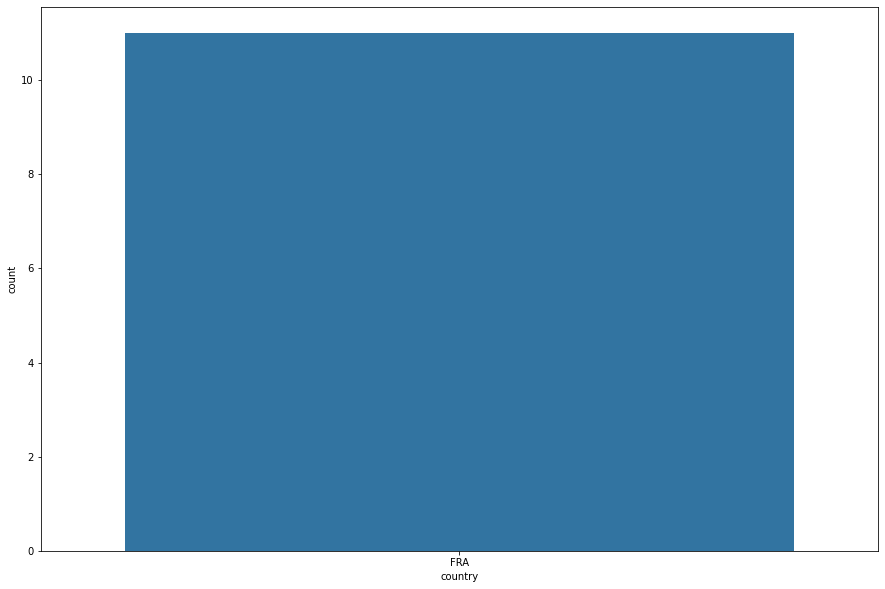

In [37]:
plt.figure(figsize=(15,10))

sns.countplot(
    x = 'country',
    data = join.loc[join.runner_id == 'LELEVETCyrilFRAM50.0']
)

In [83]:
count = 0
total_races = len(race)
for r in new_race.race_year_id.unique():
    country = join.loc[join.race_year_id == r].iloc[0].country
    nat_first_df = join.loc[(join.race_year_id == r) & (join.ranking == 1)]
    if nat_first_df.shape[0] > 0:
        if country == nat_first_df.iloc[0]['nationality']:
            count += 1
    
print(f"{total_races=}")
print(f"{count=}")      

total_races=1133
count=838


In [148]:
def get_first_place_local_rate(join,new_race, pas):

    race_fore_decils = []
    race_perc_foreigners = []
    for i in np.arange(2 * pas,10, pas):
        race_fore_decils.append(new_race.loc[new_race.perc_fore >= i/10])
        race_perc_foreigners.append(i*10)
        
    perc_first_at_home = []
    for d in tqdm(race_fore_decils):
        count = 0
        total_races = len(d)
        for r in d.race_year_id.unique():
            country = join.loc[join.race_year_id == r].iloc[0].country
            nat_first_df = join.loc[(join.race_year_id == r) & (join.ranking == 1)]
            if nat_first_df.shape[0] > 0:
                if country == nat_first_df.iloc[0]['nationality']:
                    count += 1

        perc_first_at_home.append(count / total_races * 100)

    df = pd.DataFrame({'race_perc_foreigner': race_perc_foreigners, 'perc_first_local': perc_first_at_home})

    return df

In [149]:
df = get_first_place_local_rate(join,new_race, 0.1)

100%|███████████████████████████████████████████| 98/98 [01:10<00:00,  1.39it/s]


<AxesSubplot:xlabel='race_perc_foreigner', ylabel='perc_first_local'>

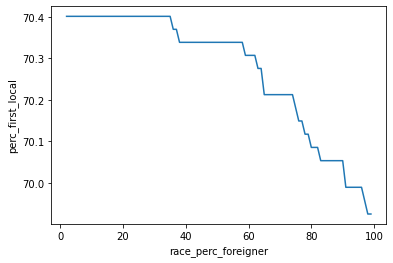

In [150]:
sns.lineplot(
    x = "race_perc_foreigner",
    y = "perc_first_local",
    data = df
)

<AxesSubplot:xlabel='perc_fore'>

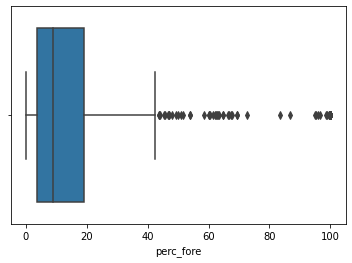

In [126]:
sns.boxplot(x = new_race.perc_fore)

In [223]:
def get_ranking_local_rate(join,new_race, max_relative_ranking = 1):
        
    new_race = new_race.loc[(new_race.perc_fore > 0) & (new_race.perc_fore < 100)]
    avg_local_runners_ranking_list = []
    avg_foreign_runners_ranking_list = []
    for r in new_race.race_year_id.unique():
            ra = join.loc[(join.race_year_id == r)]
            country = ra.loc[ra.race_year_id == r].iloc[0].country
            avg_local_runners_ranking = ra.loc[(ra.nationality == country) & (ra.relative_ranking <= max_relative_ranking)].relative_ranking.mean()
            avg_foreign_runners_ranking = ra.loc[(ra.nationality != country) & (ra.relative_ranking <= max_relative_ranking)].relative_ranking.mean()

            avg_local_runners_ranking_list.append(avg_local_runners_ranking)
            avg_foreign_runners_ranking_list.append(avg_foreign_runners_ranking)
            race_perc_foreigner = new_race.perc_fore

    df = pd.DataFrame({'race_perc_foreigner': race_perc_foreigner,
                       'avg_local_runners_ranking': avg_local_runners_ranking_list,
                       'avg_foreign_runners_ranking': avg_foreign_runners_ranking_list
                      })

    return df.fillna(0)

In [232]:
df = get_ranking_local_rate(join,new_race, 0.3)

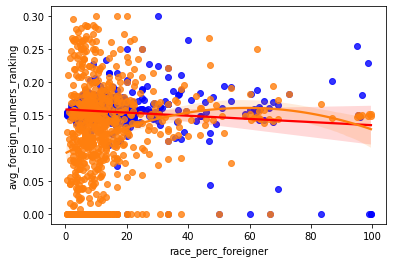

In [233]:
cdf = df
ax = sns.regplot(
    x = 'race_perc_foreigner',
    y = 'avg_local_runners_ranking',
    scatter_kws={"color": "blue"}, line_kws={"color": "red"},
    data = cdf
)
ax = sns.regplot(
    x = 'race_perc_foreigner',
    y = 'avg_foreign_runners_ranking',
    data = cdf,
    order = 2
)